In [ ]:
# instalar o kaggle para consedir aceder ao dataset M5
pip install kaggle

# Criação de uma pasta para o API do kaggle. Como o usuário tem um espaço isso interfere com os argumentos então temos de colocar
# a diretoria entre aspas duplas
New-Item -ItemType Directory -Path "C:\Users\Catarina Ferreira\.kaggle"

# Configurar o API do Kaggle pelo próprio website onde na conta foi criado um token e colocar o ficheiro criado na diretoria previamente criada
Move-Item -Path "kaggle.json" -Destination "C:\Users\Catarina Ferreira\.kaggle\kaggle.json"

# Baixar o conjunto de dados M5 do Kaggle após aceitar as regras da competição
kaggle competitions download -c m5-forecasting-accuracy

# Descompactar o zip com os ficheiros do M5
tar -xzvf m5-forecasting-accuracy.zip

In [12]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Passo 1: Carregar os dados
calendar = pd.read_csv('calendar.csv')
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sell_prices = pd.read_csv('sell_prices.csv')

# Passo 2: Pré-processamento dos dados
# Identificar colunas numéricas e categóricas
numeric_features = ['d_' + str(i) for i in range(1, 1914)]  # Datas de vendas
categorical_features = []

# Verificar se as colunas de eventos estão presentes nos dados
if 'event_name_1' in sales_train_validation.columns:
    categorical_features.extend(['event_name_1', 'event_type_1'])
if 'event_name_2' in sales_train_validation.columns:
    categorical_features.extend(['event_name_2', 'event_type_2'])

# Pipeline para pré-processamento das features numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Preencher valores ausentes com a mediana
    ('scaler', StandardScaler())  # Padronizar os dados
])

# Pipeline para pré-processamento das features categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Preencher valores ausentes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar variáveis categóricas
])

# Combinar os pré-processadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicar o pipeline aos dados
processed_data = pipeline.fit_transform(sales_train_validation)

# O processed_data agora contém os dados pré-processados


Primeiras linhas do dataset:
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_19

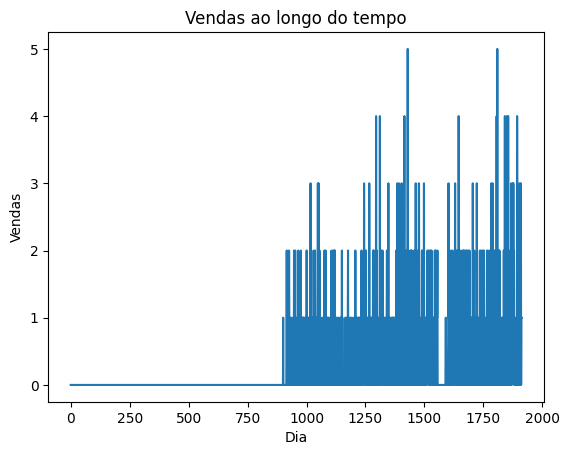


Categorias de produtos:
['HOBBIES' 'HOUSEHOLD' 'FOODS']

Lojas:
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']

Quantidade de dados ausentes por coluna:
id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64


In [13]:
import pandas as pd

# Carregar os dados
sales_train_validation = pd.read_csv('sales_train_validation.csv')

# Visualização das primeiras linhas do dataset
print("Primeiras linhas do dataset:")
print(sales_train_validation.head())

# Resumo estatístico das variáveis numéricas
print("\nResumo estatístico das variáveis numéricas:")
print(sales_train_validation.describe())

# Visualização da distribuição das vendas ao longo do tempo (por exemplo, primeiras 100 dias)
import matplotlib.pyplot as plt
plt.plot(sales_train_validation.iloc[0, 6:].values)
plt.xlabel('Dia')
plt.ylabel('Vendas')
plt.title('Vendas ao longo do tempo')
plt.show()

# Verificar as categorias de produtos
print("\nCategorias de produtos:")
print(sales_train_validation['cat_id'].unique())

# Verificar as lojas
print("\nLojas:")
print(sales_train_validation['store_id'].unique())

# Verificar a quantidade de dados ausentes
print("\nQuantidade de dados ausentes por coluna:")
print(sales_train_validation.isnull().sum())


In [ ]:

# Passo 2: Explorar e entender os dados
# (Você pode realizar análises exploratórias aqui para entender melhor os dados)

# Passo 3: Pré-processamento dos dados
# (Dependendo do modelo escolhido, você pode precisar fazer mais pré-processamento)

# Juntar os dados de venda com os preços de venda
sales_merged = sales_train_validation.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'])

# Converter a data para o formato datetime
sales_merged['date'] = pd.to_datetime(calendar['date'])

# Passo 4: Construir e treinar um modelo de previsão
# Separar os dados em features e target
X = sales_merged.drop(columns=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales'])
y = sales_merged['sales']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar e treinar o modelo de regressão
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Passo 5: Avaliar o desempenho do modelo
# Prever os valores para os dados de teste
predictions = model.predict(X_test)

# Avaliar o desempenho do modelo
mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')

# Passo 6: Fazer previsões
# Você pode usar o modelo treinado para fazer previsões futuras